# <center> Feature Selection for Decision Tree and Gaussian Naive Bayes </center>

This code runs two different features selection strategies on a Regression Decision Tree and a Gaussian Naive Bayes model. After running...

First, we have our shebang and imports:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
from graphviz import Source
from sklearn import metrics, tree, naive_bayes
from sklearn.tree import export_graphviz
from pandas import DataFrame
import numpy as np
import heapq

%matplotlib inline

Next, we read our data from a CSV, into a pandas Dataframe. We also do some quick preprocessing to prepare the data to be input into the model. This includes seperating the labels from the instances and stripping away the home/away team features.

In [2]:
# Initial Data
training = DataFrame.from_csv("../data/raw_data_normalized_t.csv")
testing = DataFrame.from_csv("../data/raw_data_normalized_test.csv")

# Data - NA's
training = training.dropna(axis=1, how='all')
testing = testing.dropna(axis=1, how='all')
training = training.dropna(axis=0, how='any')
testing = testing.dropna(axis=0, how='any')

# Just the Labels
trainLabel = training['Label']
testLabel = testing['Label']

# Drop Home, Away, and Label from the data instances
training = training.drop('away_team', 1).drop('home_team', 1).drop("Label", 1)
testing = testing.drop('away_team', 1).drop('home_team', 1).drop("Label", 1)


This function contains the graphing components of matplotlib and is used by the following feature selection methods to visualize how adding features affects the F1 score of a model

In [3]:
# x = x-coordiantes, y = y-coordinates, which = "Dependant" or "Independant" (for the title)
def graph(x, y, which):
    # As a line graph
    plt.plot(x, y, '-')
    plt.title('Incrementally Adding Best ' + which + ' Features')
    plt.ylabel('F1 Score')
    plt.xlabel('Number of Features')
    plt.show()
    
    # As a bar chart
    plt.bar(x, y)
    plt.title('Incrementally Adding Best ' + which + ' Features')
    plt.ylabel('F1 Score')
    plt.xlabel('Number of Features')
    plt.show()

# <center> Best Independant Feature </center>
Here we have the first method of feature selection. This function runs through every feature in the data and constructs a model - either a Decision Tree or Gaussian Naive Bayes - that has only that one feature in it. It then ranks the features by the F1 score of model they generate. Finally, a model is constructed by incrementally adding features to it in rank order. In this way, we construct a model by adding the next best independant feature to it. At each iteration, the F1 score of the model is recorded, and once the final model is tested, this function will generate a graph of F1 score vs. number of features. Once completed, it will return a list of features in rank order.

In [4]:
# train_d = training data, test_d = testing data, machine = type of model
def feature_selection_best_ind(train_d, test_d, machine):
    # Keep a priority queue in order to rank the features
    pq = []
    
    # Rank the features in order of F1 score when operating alone
    for feature in train_d.columns:
        # Select one feature only
        train = train_d[feature]
        test = test_d[feature]

        # Determine its F1 score       
        machine.fit(train.as_matrix().reshape(-1,1), trainLabel.as_matrix() )
        F1 = metrics.f1_score(np.array(testLabel), machine.predict(test.as_matrix().reshape(-1,1)).round())

        # Add it to the priority queue
        heapq.heappush(pq, (-F1, feature))

    # Variables for looping
    features = []
    x = []
    y = []
    
    # Incrementally add features and store F1 scores
    while pq:
        # Consider another feature
        chosen = heapq.heappop(pq)
        features.append(chosen[1])
        
        train = train_d[features]
        test = test_d[features]
        
        # Determine the F1 score of the model
        machine.fit(train.as_matrix(), trainLabel.as_matrix() )
        F1 = metrics.f1_score(np.array(testLabel), machine.predict(test.as_matrix()).round())

        # This will print out the F1 score of each iteration, feel free to uncomment if you want to see it.
        #print(len(features), chosen[1], F1)
        
        # Grab the F1 scores for graphing
        x.append(len(features))
        y.append(F1)
    
    # Graph the F1 scores as a function
    graph(x, y, "Independant")

    
    return features

# <center> Best Dependant Feature </center>
Our second method of feature selection is similar to the first, however this time we consider which feature will, when added to the current model, result in the best F1 score. In this way we are recursively selecting the best dependant feature. Initially, the model is empty, so the best independant feature will also be the best dependant feature. After that, the features selected inevitably diverge. This method will return a list of features in the order they are added to the model. Additionally, the x and y parameters build lists which will be used to graph the F1 score vs number of features graph.

In [5]:
def feature_selection_best_dep(train_d, test_d, machine, features, x, y):
    # Priority Queue for ranking features by their F1 score
    pq = []

    # Rank the features in order of F1 score when operating with current model
    for feature in train_d.columns:
        # Don't double feature
        if feature in features:
            continue
        
        # Add a feature to the model
        features.append(feature)
        train = train_d[features]
        test = test_d[features]
           
        # Determine its F1 score
        F1 = 0
        
        if len(features) == 1:
            machine.fit(train.as_matrix().reshape(-1,1), trainLabel.as_matrix() )
            F1 = metrics.f1_score(np.array(testLabel), machine.predict(test.as_matrix().reshape(-1,1)).round())
        else:
            machine.fit(train.as_matrix(), trainLabel.as_matrix() )
            F1 = metrics.f1_score(np.array(testLabel), machine.predict(test.as_matrix()).round())

        
        # Throw that feature away
        features.pop()
        
        # Push the new feature onto the pq
        heapq.heappush(pq, (-F1, feature))
    

    # If pq is empty, adding additional features won't improve the model
    if not pq:
        return features

    # Take the feature that gives the best improvement and build off of that
    chosen = heapq.heappop(pq)
    features.append(chosen[1])
    
    # This will print out the F1 scores of each iteration. Feel free to uncomment it if you wish.
    #print(len(features), chosen)
    
    # Store number of features and -F1 score (pq is a min heap)
    x.append(len(features))
    y.append(-chosen[0])
    
    # Recursive call to find another feature
    return feature_selection_best_dep(train_d, test_d, machine, features, x, y)

# <center> Finding the Best Models </center>
The next few functions handle finding and evaluating the best models that our feature selection comes up with. Because of how erratic the independent feature selection is, we don't use it to find 'best models' perse, but rather use it to see what the best single features are for each model.

This function prints the Confusing Matrix, Accuracy, F1 Score, Precision, and Recall for a given model.

In [6]:
# machine = Decision Tree or Gaussian Naive Bayes, [testing training]_d = [testing training] data to use for this model
def printMetrics(machine, training_d, testing_d):
    pred = []
    # Get the predictions
    if len(training_d) == 1:
        machine.fit(training_d.as_matrix().reshape(-1,1), trainLabel.as_matrix() )
        pred = machine.predict( testing_d.as_matrix().reshape(-1,1) ).round()
    else:
        machine.fit(training_d.as_matrix(), trainLabel.as_matrix() )
        pred = machine.predict( testing_d.as_matrix() ).round()

    # Print the metrics
    print("Confusion Matrix:\n", metrics.confusion_matrix( np.array(testLabel), pred))
    print("Accuracy:", metrics.accuracy_score( np.array(testLabel), pred))
    print("F1 Score:", metrics.f1_score( np.array(testLabel), pred))
    print("Precision:", metrics.precision_score( np.array(testLabel),pred))
    print("Recall:", metrics.recall_score( np.array(testLabel), pred))

The following function seeks to find peaks in the graph because those are interesting to us. It considers models that take at most 5, 10, 15, or 20 features and determines the feature set that gives the maximum F1 score. It then returns a dictionary that maps a print-friendly string with the feature set that it finds.

In [7]:
def findPeaks(features, F1s):
    # We care about early peaks, not late peaks
    maxFeatures = [5, 10, 15, 20]
    ret = {}
    
    # For each of these marks, find the maximum and the features that give that model
    for nFeatures in maxFeatures:
        bestNum = F1s.index(max(F1s[:nFeatures]))
        bestFeatures = features[:bestNum]
        ret["Maximum F1 on <" + str(nFeatures) + " Features is found with the following features: "] = list(bestFeatures)
    
    return ret

This is a wrapper for running and graphing the outputs of the two feature selection methods on both models. It also handles finding the best feature sets and outputs the best 10 independent features for the model.

In [8]:
def run(training, testing, best=0):
    for model, machine in enumerate([tree.DecisionTreeRegressor(criterion="mse"), naive_bayes.GaussianNB()]):
        # Make output clearer
        if model == 0:
            print("Decision Tree")
        elif model == 1:
            print("Gaussian Naive Bayes")

        # Independant feature selection
        capture = feature_selection_best_ind(training, testing, machine)
        
        # If flag is set, show the best parts
        if best:
            print("The best 10 independant features are:")
            print(capture[:10])
            print("")
        
        # Prepare variables
        x = []
        y = []
        print("Recursing will take a few seconds...")
        
        # Run and graph dependant feature selection
        capture = feature_selection_best_dep(training, testing, machine, [], x, y)
        graph(x, y, "Dependant")
        
        # We care About best dependent models
        if best:
            bestFeatures = findPeaks(capture, y)
            for key, value in bestFeatures.items():
                print(key, value)
                printMetrics(machine, training[value], testing[value])

The next cell only run and graph both models on both methods, not output any metrics.

Decision Tree


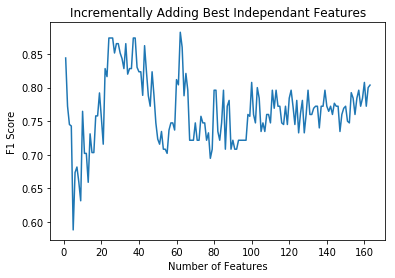

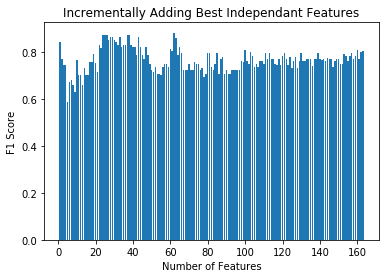

Recursing will take a few seconds...


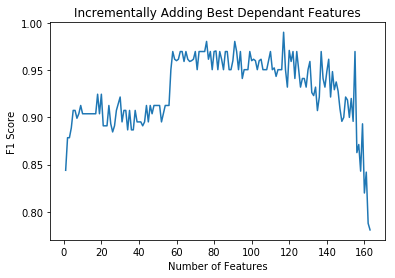

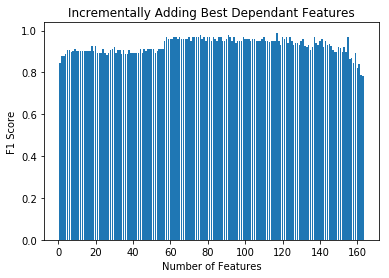

Gaussian Naive Bayes


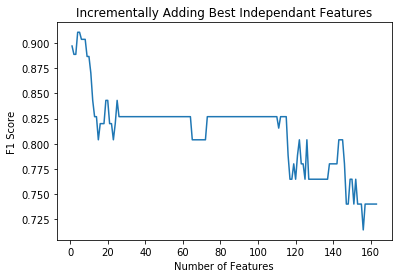

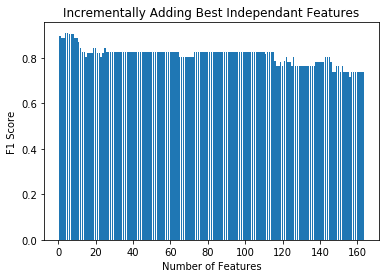

Recursing will take a few seconds...


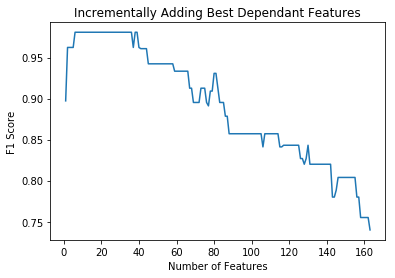

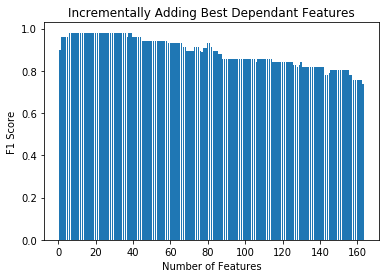

In [ ]:
run(training, testing)

The next cell will run, graph, and output metrics on both models on both methods.

Decision Tree


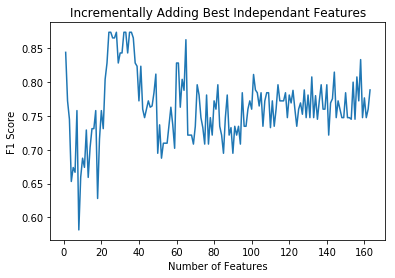

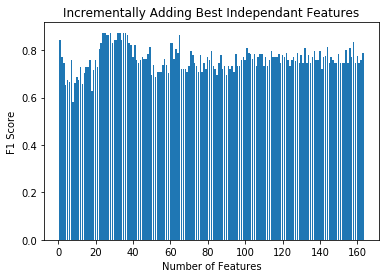

The best 10 independant features are:
['d_ Average_Team_Passer_Rating', 'd_ Yards_per_Point', 'd_OffIsoPPP', 'd_ Opponent_Punts_per_Play', 'd_ Points_per_Play_Margin', 'd_ Penalties_per_Play', 'd_OffSuccRate', 'd_ Opponent_Rushing_Yards_per_Game', 'd_ Opponent_Pass_Attempts_per_Game', 'd_ Opp_Overtime_Points/Game']

Recursing will take a few seconds...


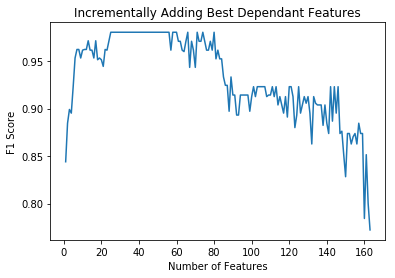

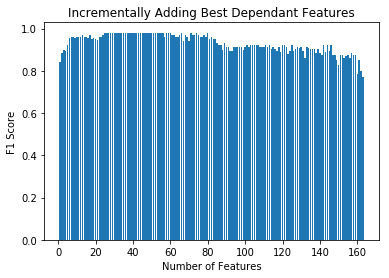

Maximum F1 on <20 Features is found with the following features:  ['d_ Average_Team_Passer_Rating', 'd_ Field_Goals_Made_per_Game', 'd_ Opponent_Completion_Percentage', 'd_ Opponent_Third_Down_Conversion_Percentage', 'd_ Fumble_Recovery_Percentage', 'd_ Completion_Percentage', 'd_ Opponent_Penalties_per_Play', 'd_DefSuccRate', 'd_ 1st_Half_Time_of_Possession_Share_%', 'd_ Opponent_Turnover_Margin_per_Game', 'd_ Opponent_Punts_per_Offensive_Score', 'd_ Opponent_Fumbles_Not_Lost_per_Game']
Confusion Matrix:
 [[17  6]
 [ 7 44]]
Accuracy: 0.824324324324
F1 Score: 0.871287128713
Precision: 0.88
Recall: 0.862745098039
Maximum F1 on <10 Features is found with the following features:  ['d_ Average_Team_Passer_Rating', 'd_ Field_Goals_Made_per_Game', 'd_ Opponent_Completion_Percentage', 'd_ Opponent_Third_Down_Conversion_Percentage', 'd_ Fumble_Recovery_Percentage', 'd_ Completion_Percentage']
Confusion Matrix:
 [[18  5]
 [ 2 49]]
Accuracy: 0.905405405405
F1 Score: 0.933333333333
Precision: 0.9

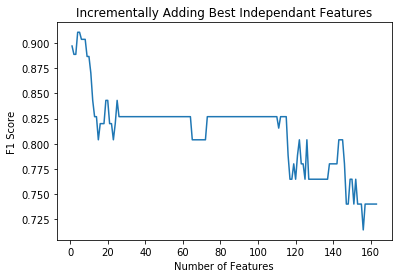

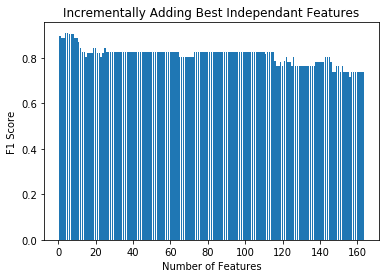

The best 10 independant features are:
['d_RecRank', 'd_RecPoints', 'd_ Opponent_Third_Down_Conversion_Percentage', 'd_ Yards_per_Point', 'd_DefSP', 'd_ Points_per_Play', 'd_ 1st_Half_Points/Game', 'd_ Opp_2nd_Quarter_Points/Game', 'd_ Offensive_Points_per_Game_(Estimated)', 'd_ Offensive_Touchdowns_per_Game']

Recursing will take a few seconds...


In [ ]:
run(training, testing, 1)